In [4]:
#Google Analytics Customer Revenue Prediction

import os

import warnings
warnings.filterwarnings('ignore')

# basic libraries for reading data and plotting:
#------------------------------
import pandas as pd
import dask.dataframe as dd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import json
from pandas.io.json import json_normalize #package for flattening json in pandas df

# models,scoring, hyperparameter tuning libraries:
# --------------------------------------
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor
#import lightgbm as lgb # Light GBM model ####
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

#from mlxtend.classifier import StackingClassifier   #####

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from random import random
from random import randrange




#for results table:
from prettytable import PrettyTable
from IPython.display import Image




In [78]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'] # we are definig a list of json column names

    df = pd.read_csv(csv_path,
                     converters={
                         column: json.loads for column in JSON_COLUMNS}, # It will create JSON object for every json column
                     dtype={'fullVisitorId': 'str'},  # we are considering 'fullvisitor id as string'
                     nrows=nrows)

    for column in tqdm(JSON_COLUMNS):
        column_as_df = json_normalize(df[column]) # json_normalize will return a flatten dataframe of json columns
        
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns] # we are taking  
                                                                                                           # column names
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True) # we are dropping json column and
                                                                                            # and merging data frame with parsed columns
        
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    
    return df


In [79]:
train_df = load_df(("train_v2.csv") , nrows=50000)
test_df  = load_df("test_v2.csv" , nrows=50000)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.98s/it]


Loaded train_v2.csv. Shape: (50000, 59)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.99s/it]


Loaded test_v2.csv. Shape: (50000, 59)


In [80]:
train_df.nunique() #ensuring if there is any unique values in the dataset

channelGrouping                                          8
customDimensions                                         6
date                                                    19
fullVisitorId                                        45639
hits                                                 47918
socialEngagementType                                     1
visitId                                              49045
visitNumber                                            150
visitStartTime                                       49042
device.browser                                          30
device.browserVersion                                    1
device.browserSize                                       1
device.operatingSystem                                  17
device.operatingSystemVersion                            1
device.isMobile                                          2
device.mobileDeviceBranding                              1
device.mobileDeviceModel                                

#### observations ::  if the same unique value present in all rows of any given feature means no need to use those features. since that feature value is constant across all records means it won't affect our final predicting variable. so we need to drop all such values.

In [81]:
column_names = train_df.columns.to_list()

unique_value_columns=[]

for column in column_names:
    count = train_df[column].nunique()
    if count==1:
        del train_df[column]
        unique_value_columns.append(column)
        
        
column_names1 = test_df.columns.to_list()

unique_value_columns1=[]

for column in column_names1:
    count1 = test_df[column].nunique()
    if count1==1:
        del test_df[column]
        unique_value_columns1.append(column)      
        
        
        
print("after dropping some columns our data shape is : {}".format(train_df.shape))
print("after dropping some columns our data shape is : {}".format(test_df.shape))
train_df.head(2)
test_df.head(2)

after dropping some columns our data shape is : (50000, 36)
after dropping some columns our data shape is : (50000, 35)


,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,totals.totalTransactionRevenue,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1526099341,2,1526099341,Chrome,Android,...,NaN,(not set),(not set),google,organic,(not provided),(not set),NaN,NaN,NaN
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",1526064483,166,1526064483,Chrome,Macintosh,...,NaN,(not set),(not set),(direct),(none),(not set),(not set),NaN,NaN,NaN


In [82]:
# now observing how many missing values in our modified data.
# referance : https://medium.com/dunder-data/finding-the-percentage-of-missing-values-in-a-pandas-dataframe-a04fa00f84ab


percent_missing = train_df.isnull().sum() * 100 / len(train_df)  #{ (total nulls in particular column*100)/total no.of rows }
missing_value_df = pd.DataFrame({'column_name': train_df.columns,
                                 'percent_missing': percent_missing})

missing_value_df

,column_name,percent_missing
channelGrouping,channelGrouping,0.000
customDimensions,customDimensions,0.000
date,date,0.000
fullVisitorId,fullVisitorId,0.000
hits,hits,0.000
visitId,visitId,0.000
visitNumber,visitNumber,0.000
visitStartTime,visitStartTime,0.000
device.browser,device.browser,0.000
device.operatingSystem,device.operatingSystem,0.000


#### observations:: on obeserving the missing values percentage we get a conclusion that there are only few coloumns which have 0% of missing values, most of coloumns have some missing values in it.And some coloumns have 99% percentage of missing values.

<AxesSubplot:xlabel='column_name'>

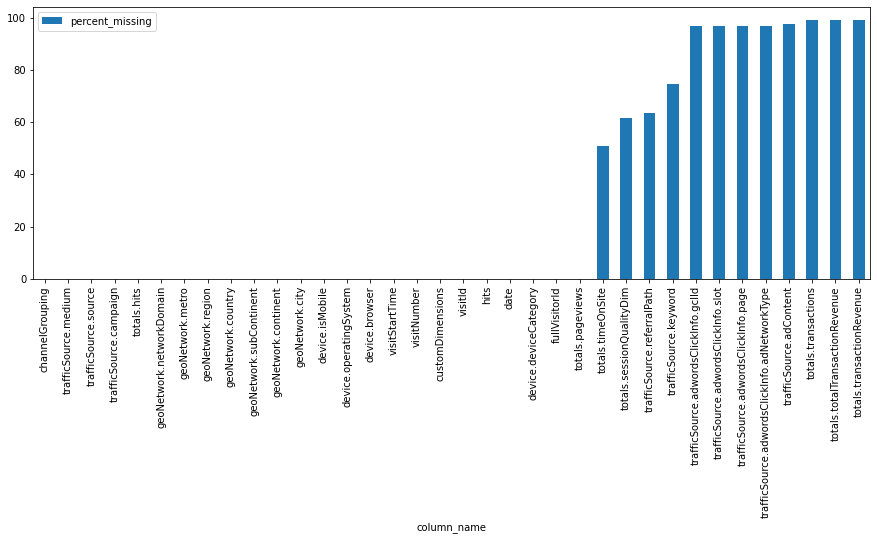

In [83]:
train_df['totals.timeOnSite']

# we will  obersve the above missing values data by plotting the coloumn "total.timeOnSite ":
missing_value_df.sort_values("percent_missing").plot(kind='bar',x='column_name',y='percent_missing',figsize=(15, 5))

#### now we are going to analyse missing value coloumns and try to fill them with some of the relevant data.

#### 1: totals.timeOnSite : since it indicates for how much time do a customer is online in a site. If there is no any data for it that can be determined as customer was not on the site.

In [84]:
# so for all missing values in 'timeOnSite' feature we will fill with zeros.
train_df['totals.timeOnSite'].fillna(0, inplace=True)
test_df['totals.timeOnSite'].fillna(0, inplace=True)

#### 2. totals.sessionQualityDim : An estimate of how close a particular session was to transacting, ranging from 1 to 100, calculated for each session. A value closer to 1 indicates a low session quality, or far from transacting, while a value closer to 100 indicates a high session quality, or very close to transacting. A value of 0 indicates that Session Quality is not calculated for the selected time range.

In [85]:
# so for all missing values in 'sessionQualityDim' feature we will fill with zeros.

train_df['totals.sessionQualityDim'].fillna(0, inplace=True)
test_df['totals.sessionQualityDim'].fillna(0, inplace=True)

#### 3.trafficSource.keyword: For manual campaign tracking, it is the value of the utm_term campaign tracking parameter. Otherwise, its value is (not set)

In [86]:
train_df['trafficSource.keyword'].head(5)

0      water bottle
1               NaN
2               NaN
3    (not provided)
4    (not provided)
Name: trafficSource.keyword, dtype: object

In [87]:
print("no.of unique values or keywords : {0}".format(train_df['trafficSource.keyword'].nunique()))
print("no.of records having 'nan' are : {0}".format(train_df['trafficSource.keyword'].astype(str).str.contains("nan").sum(axis=0)))
print("no.of records having '(not provided or missing)' are : {0}".format(train_df['trafficSource.keyword'].astype(str).str.contains("(not provided or missing)").sum(axis=0)))

no.of unique values or keywords : 178
no.of records having 'nan' are : 37218
no.of records having '(not provided or missing)' are : 0


In [88]:
# so here idea is we will repalce the all 'nan','(not provided)' with 'others'
train_df['trafficSource.keyword'].replace(['nan','NaN','(not provided)'], 'others',inplace=True)
train_df['trafficSource.keyword'].fillna('others', inplace=True)

test_df['trafficSource.keyword'].replace(['nan','NaN','(not provided)'], 'others',inplace=True)
test_df['trafficSource.keyword'].fillna('others', inplace=True)

In [89]:
train_df['trafficSource.keyword'].isnull().sum(axis=0)
test_df['trafficSource.keyword'].isnull().sum(axis=0)

#having no null values.

0

#### 4.trafficSource.referralPath : About 60% of data in this feature having 'nan'., so istead of performing any imputation we will leave as is ., so at the time of label encoding all nan's are consider as one categgory

In [90]:
train_df['trafficSource.referralPath'].head(5)

0                                                  NaN
1    /a/google.com/transportation/mtv-services/bike...
2                                                  NaN
3                                                  NaN
4                                                  NaN
Name: trafficSource.referralPath, dtype: object

#### NOTE: trafficSource.adwordsClickInfo.gclId , trafficSource.adwordsClickInfo.page , trafficSource.adwordsClickInfo.slot , trafficSource.adwordsClickInfo.adNetworkType , trafficSource.adContent ::These features are missing in 95% of data so it's better to drop this feature instead of adding or assuming the values.


In [91]:
train_df['trafficSource.adContent'].unique()

array([nan, 'Placement Accessories 300 x 250', 'Google Merchandise Store',
       'Bags 300x250', 'Display Ad created 3/11/14',
       'Placement Office 300x250', 'Placement Drinkware 300x250',
       'Office Placement 160x600', 'Bags 336x280',
       'test_tyler_hr_merchant', 'Drinkware 336x280',
       'Official Google Merchandise', 'First Full Auto Template Test Ad',
       'Full auto ad IMAGE ONLY', '{KeyWord:Google Brand Items}',
       'Ad from 11/7/16', 'Display Ad created 3/11/15', 'Ad from 11/3/16',
       'Ad from 12/13/16', 'Google Online Store',
       'Google Merchandise Collection', 'Display Ad created 11/17/14',
       '{KeyWord:Want Google Stickers?}', '{KeyWord:Google Merchandise}',
       '{KeyWord:Google Drinkware}', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Google Branded Gear}',
       '{KeyWord:Google Branded Apparel}', 'Smart display ad - 8/17/2017',
       'BQ', 'Placement Accessores 300 x 250',
       'Placement Accessories 336 x 280',
       'Placeme

#### 6.totals.transactions:Total number of ecommerce transactions within the session., so we will fill nulls with zeros.

In [92]:
train_df['totals.transactions'].fillna(0, inplace=True)
test_df['totals.transactions'].fillna(0, inplace=True)

#### 7.totals.totalTransactionRevenue : we will impute the missing values with zero

#### 8. totals.transactionRevenue: we will impute the missing values with zero

In [93]:
train_df['totals.transactionRevenue'].fillna(0, inplace=True)
test_df['totals.transactionRevenue'].fillna(0, inplace=True)

In [94]:
# feature so we will drop this feature also.
train_df['hits'][0]

"[{'hitNumber': '1', 'time': '0', 'hour': '17', 'minute': '0', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'referer': 'https://www.google.co.uk/search?q=water+bottle&ie=utf-8&num=100&oe=utf-8&hl=en&gl=GB&uule=w+CAIQIFISCamRx0IRO1oCEXoliDJDoPjE&glp=1&gws_rd=cr&fg=1', 'page': {'pagePath': '/google+redesign/bags/water+bottles+and+tumblers', 'hostname': 'shop.googlemerchandisestore.com', 'pageTitle': 'Water Bottles & Tumblers | Drinkware | Google Merchandise Store', 'pagePathLevel1': '/google+redesign/', 'pagePathLevel2': '/bags/', 'pagePathLevel3': '/water+bottles+and+tumblers', 'pagePathLevel4': ''}, 'transaction': {'currencyCode': 'USD'}, 'item': {'currencyCode': 'USD'}, 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'landingScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tum

In [95]:
train_df['customDimensions'][0]

"[{'index': '4', 'value': 'EMEA'}]"

In [96]:
# so after preprocessing the list of Columns to be dropped in given data are:

cols_to_drop = unique_value_columns +['totals.totalTransactionRevenue']+['customDimensions'] + ['hits'] + \
            ["trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", "trafficSource.adwordsClickInfo.slot",
            "trafficSource.adwordsClickInfo.page"]


for feature in cols_to_drop:
    if feature in test_df.columns:
        del test_df[feature]
        
    if feature in train_df.columns:
        del train_df[feature]
    
print("shape of train data: {0} and test data: {1}".format(train_df.shape,test_df.shape))

shape of train data: (50000, 29) and test data: (50000, 29)


In [97]:
# our final features are:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent'],
      dtype='object')

In [98]:
# saving the preprocessed data into files:
# storing data frames as csv files:
train_df.to_csv('preprocessed_train_df.csv')
test_df.to_csv('preprocessed_test_df.csv')

# reading from files
#train_df = pd.read_csv('case study data/preprocessed_train_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)
#test_df = pd.read_csv('case study data/preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)


## ::: Exploratory data analysis ::: 

#### kaggle is using 'tranasactionRevenue' as target feature., google official anlytics document says that tranasactionRevenue' was deprecated and use 'totaltranasactionRevenue' as target feature.So we will be focusing in the feature for our performance matrix.

https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/71779


https://support.google.com/analytics/answer/3437719?hl=en

###### target feature analysis:

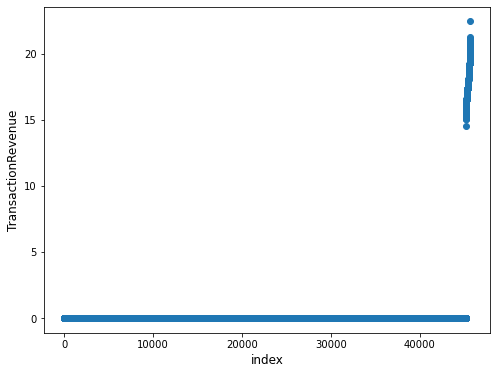

In [99]:
# credits:https://github.com/flaviassantos/google_revenue_predict/blob/master/notebooks/2.0-Exploratory-Data-Analysis.ipynb

train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float') # converting to 'float' datatype
temp = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index() # for each user we are taking sum of  
                                                                                       # all his transactions

plt.figure(figsize=(8,6))
plt.scatter(range(temp.shape[0]), np.sort(np.log1p(temp["totals.transactionRevenue"].values))) # log(transaction_revenue)
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

#### by looking at this graph we can conclude that ,most of the transactions had generated zero revenue but only few transactions had non-zero revenue. Now we will going through the non zero transaction analysis.

#### Non-zero transaction analysis.

In [100]:
non_zero_Revenue_records = 0
unique_users_with_non_zero_revenue = set()
 
for i,j in zip(train_df['totals.transactionRevenue'],train_df['fullVisitorId']):
    if i>0:
        non_zero_Revenue_records += 1
        unique_users_with_non_zero_revenue.add(j)

print("total no.of transactions with non-zero revenue out of: {0} are: {1} and \
which is about :{2} %".format(train_df.shape[0],non_zero_Revenue_records,(non_zero_Revenue_records*100)/(train_df.shape[0])))

print("\n")

print("out of {0} customers only {1} customers are generating revenue and which is about: {2}%" \
      .format(train_df['fullVisitorId'].nunique(),len(unique_users_with_non_zero_revenue),(len(unique_users_with_non_zero_revenue))*100/train_df['fullVisitorId'].nunique()))

total no.of transactions with non-zero revenue out of: 50000 are: 468 and which is about :0.936 %


out of 45639 customers only 460 customers are generating revenue and which is about: 1.0079099016192292%


#### trend analysis :: no.of visits over time: In our data each reocrd corresponds to one visit.

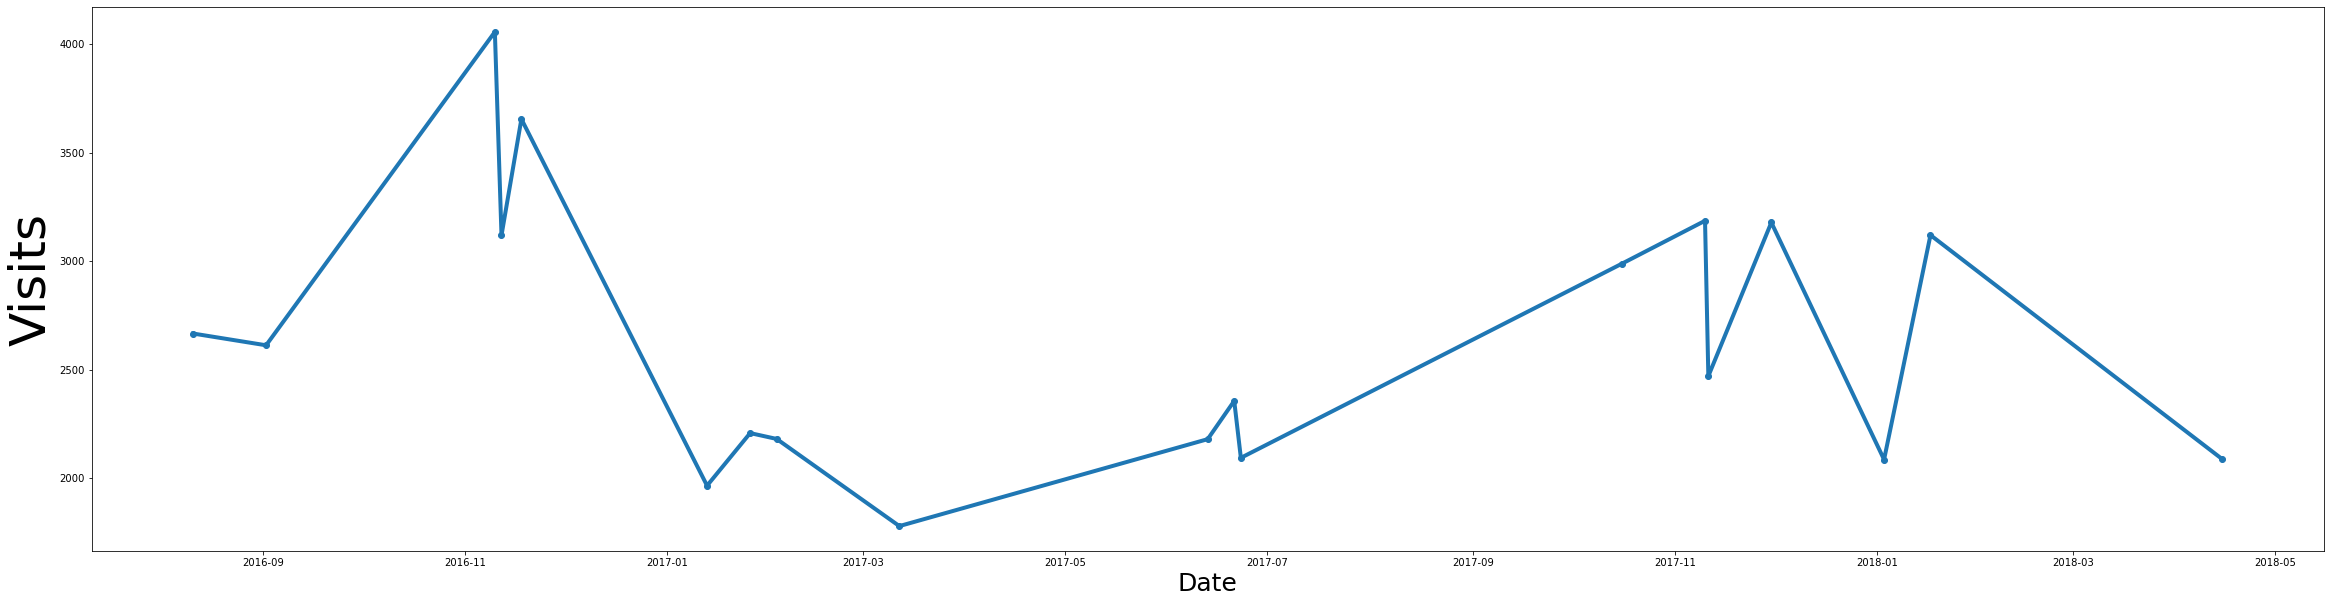

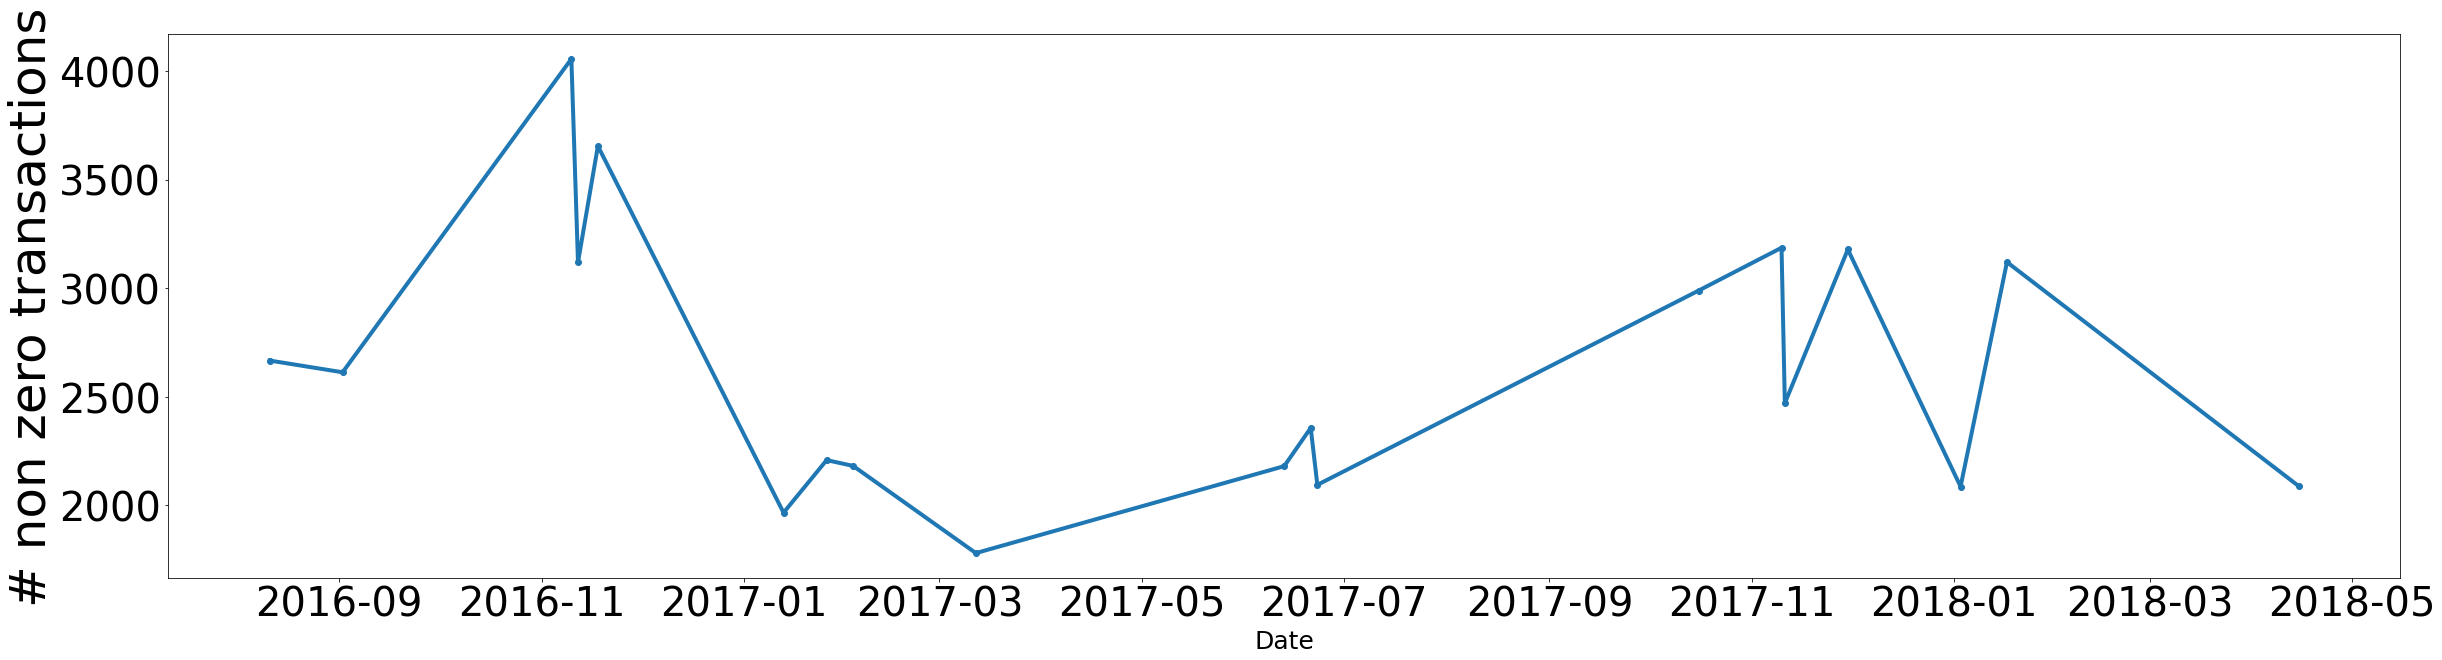

In [101]:
train_df["date"] = pd.to_datetime(train_df["date"], infer_datetime_format=True, format="%Y%m%d") # convert date feature into 
                                                                                                 # exact date format
    

# Compute count of group, excluding missing values(include only non zero values).
counts_group_date = train_df.groupby('date').count()
counts_group_date.reset_index(inplace=True) #it will create indexes from zero to len(dataframe)


# plot for no.of visits in each date :

plt.figure(figsize=(40,10))
plt.plot_date(x = counts_group_date['date'], y = counts_group_date['fullVisitorId'],linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Visits',fontsize=50)
plt.rc('xtick', labelsize=40) #increases the value's font on x-axis
plt.rc('ytick', labelsize=40) #increases the value's font on y-axis
plt.autoscale(True)
plt.show()

# plot for transcation revenue in each date :

plt.figure(figsize=(40,10))
plt.plot_date(x = counts_group_date['date'], y = counts_group_date['totals.transactionRevenue'],linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.ylabel('# non zero transactions',fontsize=50)
plt.rc('xtick', labelsize=40) #increases the value's font on x-axis
plt.rc('ytick', labelsize=40) #increases the value's font on x-axis
plt.autoscale(True)
plt.show()

#### we can conclude that form the month of october to the month of early december there is a sudden increase in the visits and non zero transactions as well.This obeservation is very useful for promotional team, they can make promotions on these months to generate more revenue.


#### Channel grouping analysis :: it can be defined as the no.of visits per each channel and total revenue generated per each channel

Text(0, 0.5, 'Transaction Revenue in Millions')

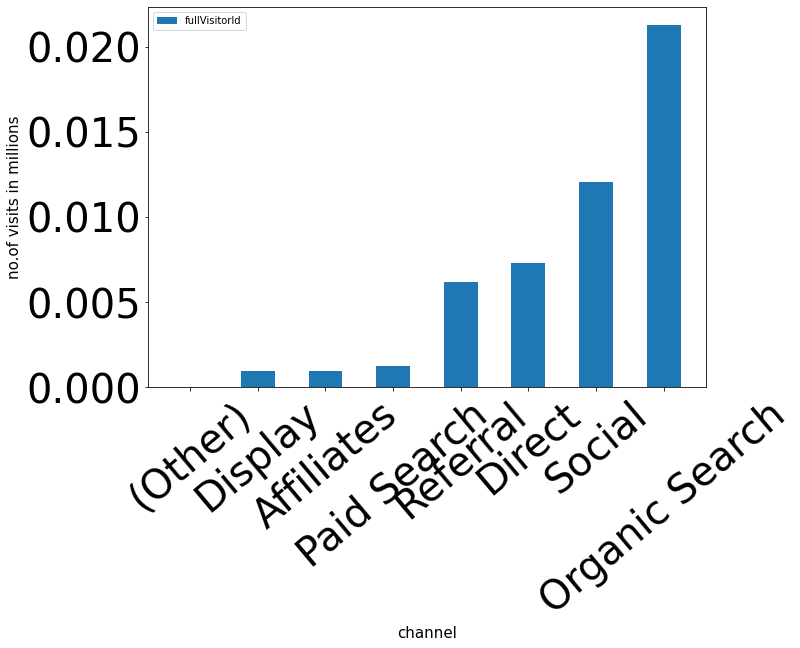

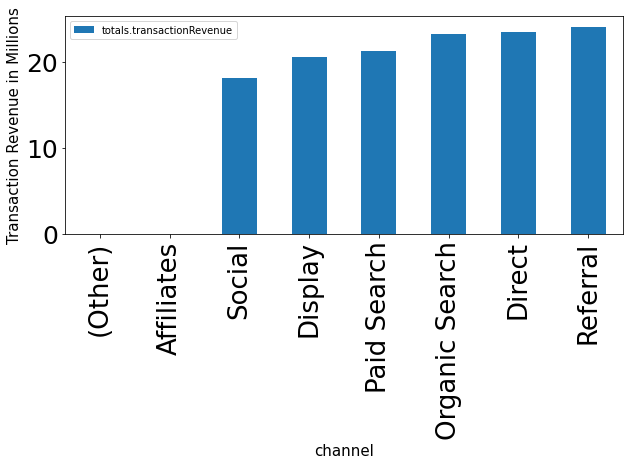

In [102]:
temp_1 = train_df.groupby('channelGrouping')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("channelGrouping")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions


# for no.of visits in each channel plot: 
# --------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**6)
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='channelGrouping',y='fullVisitorId',figsize=(10,7))
plt.autoscale(True)
plt.xticks(rotation=40)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=26) # x- axis value's font size
plt.rc('ytick', labelsize=25) # y- axis value's font size

plt.xlabel('channel', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in millions', fontsize=15) # y- axis label and font size


# for revenue in each channel plot: 
# --------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='channelGrouping',y='totals.transactionRevenue',figsize=(10,4))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=26) # x- axis value's font size
plt.rc('ytick', labelsize=25) # y- axis value's font size

plt.xlabel('channel', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

#### Here in the graphs we can conclude that most of the revenue is being generated from the "organic search" , "direct" , (also "referral")  but the number of visits is very less in "referral" and "direct". So team should try to invest more in the respective channels to generate more revenue.

#### Web-browser analysis :

#### no.of visits per each browser , total revenue generated per each browser , It's very difficult to analyse all the browsers that we had in train data;so we will analyze only top 20 browsers

In [103]:
print("total no.of unique browsers that we had in train data are: ",train_df['device.browser'].nunique())

print("\n")

print("we are analyzing the top 20 browsers and those are :\n \n",train_df['device.browser'].value_counts()[0:20])


total no.of unique browsers that we had in train data are:  30


we are analyzing the top 20 browsers and those are :
 
 Chrome                      33986
Safari                      10052
Firefox                      1911
Internet Explorer            1138
Edge                          583
Android Webview               583
Opera Mini                    428
Safari (in-app)               371
Samsung Internet              295
Opera                         281
UC Browser                    138
YaBrowser                      73
Amazon Silk                    38
Coc Coc                        37
Android Browser                22
Mozilla Compatible Agent       17
BlackBerry                      8
MRCHROME                        8
Nintendo Browser                7
Puffin                          6
Name: device.browser, dtype: int64


Text(0, 0.5, 'Transaction Revenue in Millions')

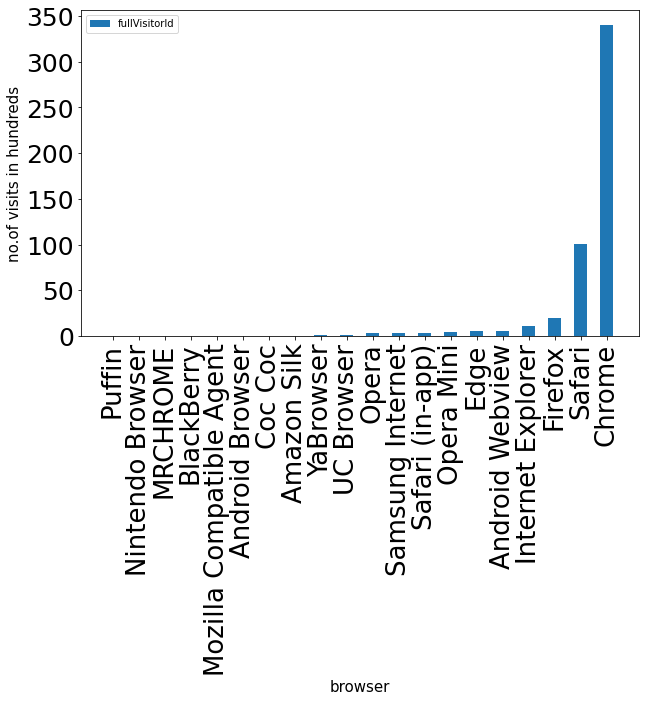

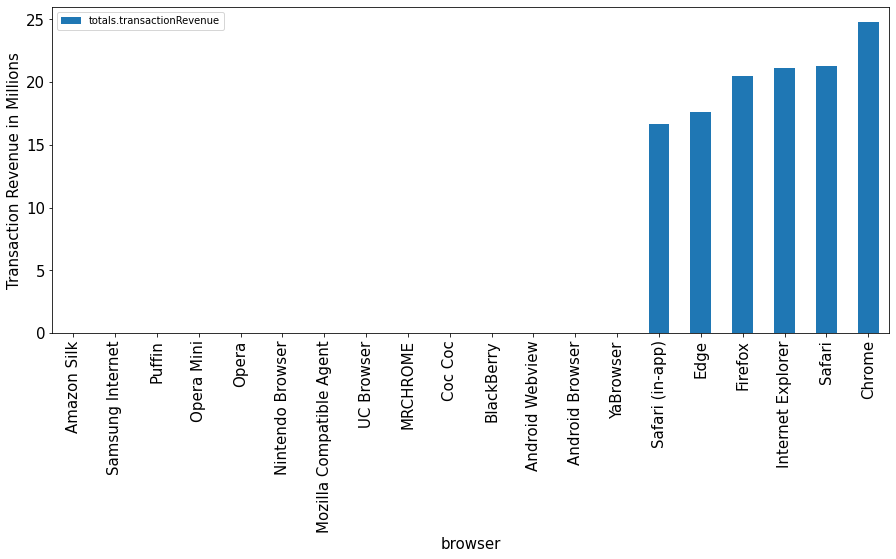

In [104]:
temp_1 = train_df.groupby('device.browser')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("device.browser")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions

top_20_browsers = train_df['device.browser'].value_counts()[:20].index.tolist() # list the top 20 browsers
temp_1 = temp_1[temp_1['device.browser'].isin(top_20_browsers)].reset_index()                 # taking only top-20 brosers group
temp_2 = temp_2[temp_2['device.browser'].isin(top_20_browsers)].reset_index()                 #  taking only top-20 brosers group 

# for no.of visits in each operatingSystem plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/10**2
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='device.browser',y='fullVisitorId',figsize=(10,6))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('browser', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in hundreds', fontsize=15) # y- axis label and font size


# for revenue in each operatingSystem plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='device.browser',y='totals.transactionRevenue',figsize=(15,6))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('browser', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

#### we can conclude that web browsers are a very important for generating the revenue.Since "chrome" is way ahead from all others so investment team can deinvest from the web browsers(except chrome and safari)  and can genrate more revenue because they are other browsers are not much useful. 

#### operatingSystem analysis

Text(0, 0.5, 'Transaction Revenue in Millions')

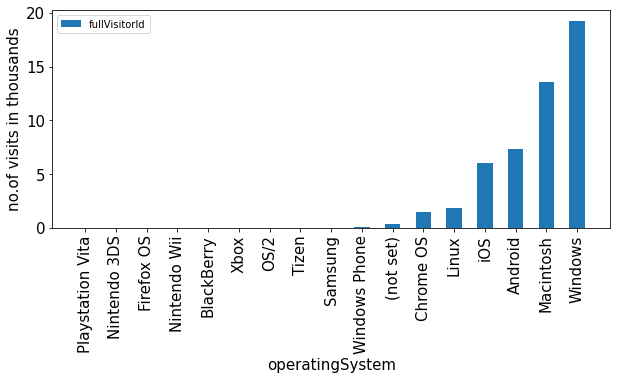

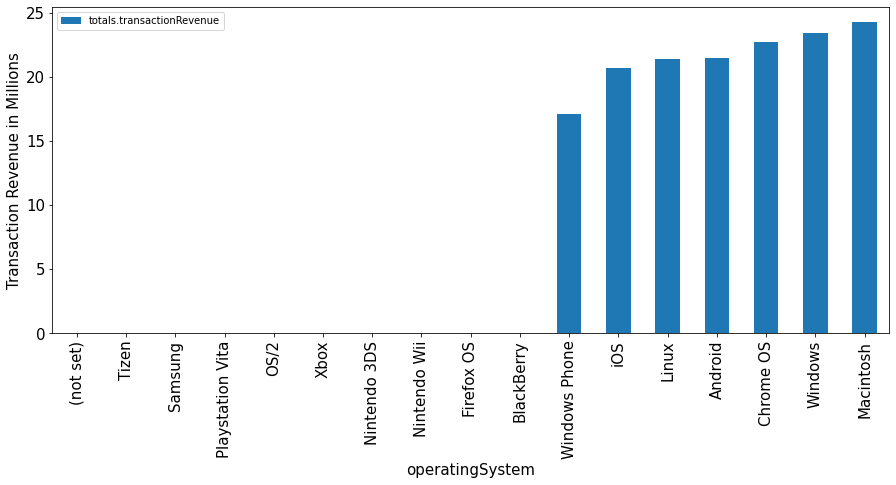

In [105]:
temp_1 = train_df.groupby('device.operatingSystem')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("device.operatingSystem")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions


# for no.of visits in each operatingSystem plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**3)
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='device.operatingSystem',y='fullVisitorId',figsize=(10,4))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('operatingSystem', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in thousands', fontsize=15) # y- axis label and font size


# for revenue in each operatingSystem plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='device.operatingSystem',y='totals.transactionRevenue',figsize=(15,6))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('operatingSystem', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

#### Most of the users are vsiting through Windows,macintosh and the most revenue is generating from windows and macintosh . If we observe carefully very less people are visting through linux and chrome os., so business team can invest very less on money for promotions on this two os platforms and can generate most revenue. Very importantly through windows phone very few people are visitng merchandise site but they are also generatng good amout of revenue. so analytics team can invest less money on the windows phone os and can generate good revenue.

#### deviceCategory analysis

#### no.of visits per each device total revenue generated per each device

Text(0, 0.5, 'Transaction Revenue in Millions')

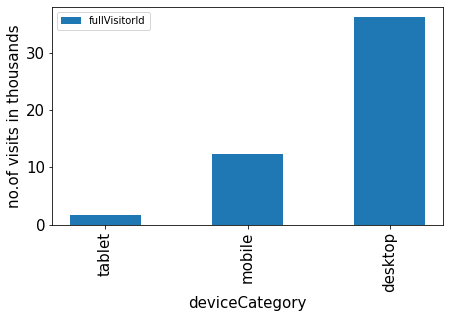

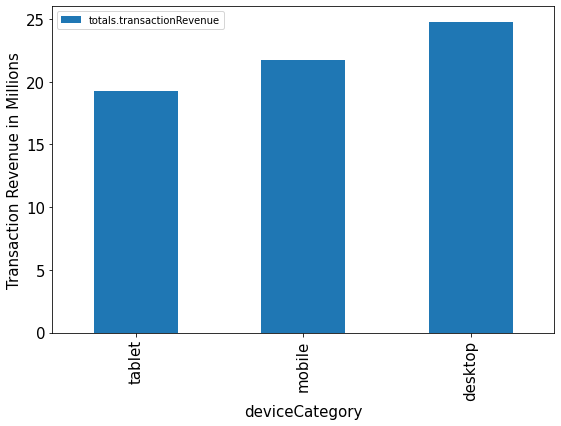

In [106]:
temp_1 = train_df.groupby('device.deviceCategory')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("device.deviceCategory")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions


# for no.of visits in each device category plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**3)
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='device.deviceCategory',y='fullVisitorId',figsize=(7,4))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('deviceCategory', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in thousands', fontsize=15) # y- axis label and font size


# for revenue in each device category plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='device.deviceCategory',y='totals.transactionRevenue',figsize=(9,6))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('deviceCategory', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

#### as we have observed that there is large number of customers are visiting through desktop and sifnificant amount of customers are visting through mobile. Where as, only few customers are visting through tablet. So the analytics team can invest less amount of money for the tablet customer , which eventually help them to generate more revenue. 

#### trafficSource analysis

#### no.of visits per each traffic source , total revenue generated per each traffic source , It's very difficult to analyse all the trafficSource that we had in train data so we will analyze only top 20 browsers

Text(0, 0.5, 'Transaction Revenue in Millions')

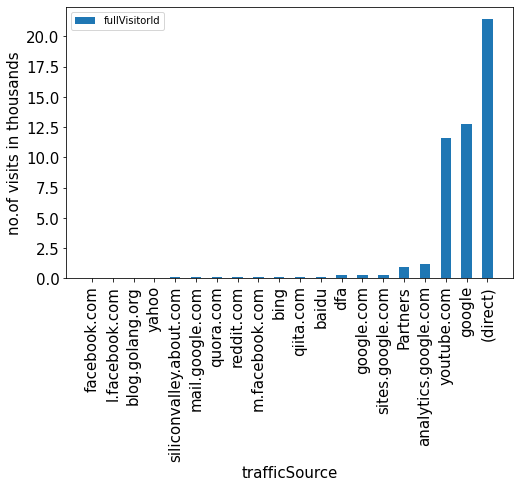

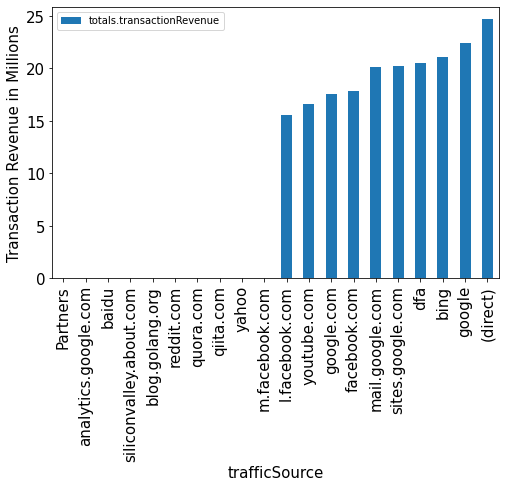

In [107]:
temp_1 = train_df.groupby('trafficSource.source')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("trafficSource.source")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions

    
top_20_traffic_sources = train_df['trafficSource.source'].value_counts()[:20].index.tolist() # list the top 20 browsers
temp_1 = temp_1[temp_1['trafficSource.source'].isin(top_20_traffic_sources)].reset_index()                 # taking only top-20 brosers group
temp_2 = temp_2[temp_2['trafficSource.source'].isin(top_20_traffic_sources)].reset_index()                 #  taking only top-20 brosers group 


# for no.of visits in each operatingSystem plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**3)
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='trafficSource.source',y='fullVisitorId',figsize=(8,5))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('trafficSource', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in thousands', fontsize=15) # y- axis label and font size


# for revenue in each operatingSystem plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='trafficSource.source',y='totals.transactionRevenue',figsize=(8,5))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('trafficSource', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

#### As we can observe that most users are visiting through google, direct,youtube and even less no.of are users are visiting thorugh 'reddit','analytics.google.com','yahoo','facebook' but significantly they are also generating good amount of revenue. so it's better to invest on this sources to gain maximum revenue.

## ::: Feature engineering :::

In [108]:
train_df['totals.transactionRevenue'].fillna(0,inplace=True) # we are filling the missing value of the feild with zeros.

In [109]:
train_df.dtypes
#train_df.shape

channelGrouping                       object
date                          datetime64[ns]
fullVisitorId                         object
visitId                                int64
visitNumber                            int64
visitStartTime                         int64
device.browser                        object
device.operatingSystem                object
device.isMobile                         bool
device.deviceCategory                 object
geoNetwork.continent                  object
geoNetwork.subContinent               object
geoNetwork.country                    object
geoNetwork.region                     object
geoNetwork.metro                      object
geoNetwork.city                       object
geoNetwork.networkDomain              object
totals.hits                           object
totals.pageviews                      object
totals.sessionQualityDim              object
totals.timeOnSite                     object
totals.transactions                   object
totals.tra

In [110]:
train_df['device.isMobile'] = train_df['device.isMobile'].astype(bool)
test_df['device.isMobile']  = test_df['device.isMobile'].astype(bool)    #converting the "device.ismobile" feature to bool

In [111]:
numeric_feat = ['visitNumber','visitStartTime','totals.hits','totals.pageviews',\
                'totals.timeOnSite','totals.transactions','totals.transactionRevenue']

for col in numeric_feat:
    train_df[col].fillna(0,inplace=True)
    train_df[col] = train_df[col].astype('float')
    
    test_df[col].fillna(0,inplace=True)
    test_df[col] = test_df[col].astype('float')
    
    
#changing the numnericals feature to the float features.

In [112]:
#for categorical feature we have to encode them into lables.

#refer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

categorical_feat = ['channelGrouping','device.browser','device.operatingSystem','device.deviceCategory',\
'geoNetwork.continent','geoNetwork.subContinent','geoNetwork.country','geoNetwork.region','geoNetwork.metro',\
'geoNetwork.city','geoNetwork.networkDomain','totals.sessionQualityDim','trafficSource.campaign','trafficSource.source',\
'trafficSource.medium','trafficSource.keyword','trafficSource.referralPath', 'trafficSource.adContent']

for feature in categorical_feat:
    
    label_encoder = preprocessing.LabelEncoder() # intitalizing label encoder object
    
    label_encoder.fit(list(train_df[feature].values.astype('str')) + list(test_df[feature].values.astype('str')))
                                                             # fit with list of variables in that feature
    
    train_df[feature] = label_encoder.transform(list(train_df[feature].values.astype('str'))) # transforming that feature
    test_df[feature]  = label_encoder.transform(list(test_df[feature].values.astype('str')))
    print("for this feature : {0} label-encoding was done succesfully".format(feature))

for this feature : channelGrouping label-encoding was done succesfully
for this feature : device.browser label-encoding was done succesfully
for this feature : device.operatingSystem label-encoding was done succesfully
for this feature : device.deviceCategory label-encoding was done succesfully
for this feature : geoNetwork.continent label-encoding was done succesfully
for this feature : geoNetwork.subContinent label-encoding was done succesfully
for this feature : geoNetwork.country label-encoding was done succesfully
for this feature : geoNetwork.region label-encoding was done succesfully
for this feature : geoNetwork.metro label-encoding was done succesfully
for this feature : geoNetwork.city label-encoding was done succesfully
for this feature : geoNetwork.networkDomain label-encoding was done succesfully
for this feature : totals.sessionQualityDim label-encoding was done succesfully
for this feature : trafficSource.campaign label-encoding was done succesfully
for this feature : tr

In [113]:
#making acopy of all the encoded features.
train_df.to_csv('label_train_df.csv')
test_df.to_csv('label_test_df.csv')

In [114]:
# reading the encoded data from the files we have just make!

train_df = pd.read_csv('label_train_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)
test_df = pd.read_csv('label_test_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

#### time series featurization 

In [115]:
# In our given data the data field is in string format., so we are converting it into normal date format:

train_df["date"] = pd.to_datetime(train_df["date"], infer_datetime_format=True, format="%Y%m%d") # convert date feature into 
                                                                                                 # exact date format
test_df["date"]  = pd.to_datetime(test_df["date"], infer_datetime_format=True, format="%Y%m%d")

In [116]:
def get_time_series_features(data,k):
    
    train_frame_k = data.loc[(data['date'] >= min(data['date']) + timedelta(days=168*(k-1))) 
                           & (data['date'] < min(data['date'])  + timedelta(days=168*k)) ]
    
    # for train_frame_1 = aug 1st 2016 to jan 15 th 2017
      #in code k=1 and min(data['date']) = aug 1st 2016
       # so it return from aug 1st 2016 to jan 15 th 2017 (since: aug 1st 2016+168)
    
    
    
    
    test_frame_k = data.loc[(data['date'] >= max(train_frame_k['date']) + timedelta(days=46)) 
                    & (data['date'] <= max(train_frame_k['date']) + timedelta(days=108))]
    
    # for test_frame_1 = mar 2nd 2017 to may 3 rd 2017
      #in code max(train_frame_k['date'])=jan 15th 2017
       # so it return from " mar 2nd 2017(since: jan 15 th 2017 + 46)" to "may 3rd 2017(since: jan 15 th 2017 + 108)"
    
    

    
    returned_customers     = set(train_frame_k["fullVisitorId"]) & set(test_frame_k["fullVisitorId"]) # intersection
    non_returned_customers = set(train_frame_k["fullVisitorId"]) - set(test_frame_k["fullVisitorId"]) # subtraction
    
    # here we will seperate the customers who came to store after cooling peroid untill 64 days after cooling period. 
    # Here cooling period means(=46 days) from "train_frame" end date
    #so now we will seperate the "train_frame_k" customers who came back to store in "test_frame_k" period.
    
    
    
    # preparing returned customers data:
    # ----------------------------------
    returned_customers_data = test_frame_k[test_frame_k['fullVisitorId'].isin(set(returned_customers))]  
    returned_customers_transactions = returned_customers_data.groupby('fullVisitorId')[['totals.transactionRevenue']]\
                                       .sum().apply(np.log1p, axis=1).reset_index()
    
    returned_customers_transactions['is_returned'] = 1
    returned_customers_transactions.rename(columns={'totals.transactionRevenue': 'revenue'}, inplace=True) 
    
    
    
    
    # preparing non-returned customers data:
    # ----------------------------------
    
    non_returned_customers_data                  = pd.DataFrame()
    non_returned_customers_data['fullVisitorId'] = list(set(non_returned_customers))
    non_returned_customers_data['is_returned']   = 0
    non_returned_customers_data['revenue']       = 0
    
    
    # so final time based featurizations(for classification model):
    #--------------------------------------------------------------------
    # we are concatinating returned and non-returned users 
    
    classification_features = pd.concat([returned_customers_transactions, non_returned_customers_data], axis=0)\
                              .reset_index(drop=True)
    
    
   
    
    # featurization for train_frame_k data :
    # ------------------------------------------
    #https://stackoverflow.com/questions/52747805/how-to-get-rid-of-nested-column-names-in-pandas-from-group-by-aggregation
    
    train_frame_k_maxdate = max(train_frame_k['date'])
    train_frame_k_mindate = min(train_frame_k['date'])
    
    train_frame_k = train_frame_k.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
        #'totals.transactionRevenue':[('transactionRevenue_sum' , lambda x:x.dropna().sum())], #summation of all the transaction amounts.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - train_frame_k_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: train_frame_k_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    train_frame_k.columns = train_frame_k.columns.droplevel() 
    
    
    # merging the two dataframe tf having features and tf_target having target variables.
    train_frame_k = pd.merge(train_frame_k, classification_features , left_on='fullVisitorId', right_on='fullVisitorId') 
    
    
    return train_frame_k

In [117]:
train_test_data = pd.concat([train_df, test_df], axis=0).reset_index()

In [118]:
%time train_frame_1 = get_time_series_features(train_test_data,1)
train_frame_1.to_pickle('train_frame_1')

Wall time: 3min


In [119]:
%time train_frame_2 = get_time_series_features(train_test_data,2)
train_frame_2.to_pickle('train_frame_2')

Wall time: 1min 52s


In [120]:
%time train_frame_3 = get_time_series_features(train_test_data,3)
train_frame_3.to_pickle('train_frame_3')

Wall time: 1min 53s


In [121]:
%time train_frame_4 = get_time_series_features(train_test_data,4)
train_frame_4.to_pickle('train_frame_4')

Wall time: 5min 20s


In [122]:
print("done!")

done!


#### Time series featurization for test data 

In [123]:
def get_time_series_features_for_test(test_data):
    
    
    test_frame_k_maxdate = max(test_data['date'])
    test_frame_k_mindate = min(test_data['date'])
    
    test_frame_k = test_data.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
           # 'totals.transactionRevenue':[('transactionRevenue_sum' , lambda x:x.dropna().sum())], #summation of all the transaction amounts.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - test_frame_k_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: test_frame_k_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    test_frame_k.columns = test_frame_k.columns.droplevel() 
    
    return test_frame_k

In [124]:
%time test_frame_5 = get_time_series_features_for_test(test_df)
test_frame_5 = test_frame_5.reset_index()

test_frame_5['revenue']     = np.nan
test_frame_5['is_returned'] = np.nan

test_frame_5.to_pickle('test_frame_5')

Wall time: 6min 39s


#### now our feature engineering task is over we are going to concatinate the whole pickle files and make a final file of feature engineering data

In [125]:
tr1 = pd.read_pickle(r'train_frame_1')
tr2 = pd.read_pickle(r'train_frame_2')
tr3 = pd.read_pickle(r'train_frame_3')
tr4 = pd.read_pickle(r'train_frame_4')
tr5 = pd.read_pickle(r'test_frame_5')

print("done")

final_featurized_data = pd.concat([tr1, tr2, tr3, tr4, tr5], axis=0, sort=False).reset_index(drop=True)

print("done")

done
done


In [126]:
#Convert the date calulcated field in days format:

final_featurized_data['interval_dates'] = final_featurized_data['interval_dates'].dt.days
final_featurized_data['first_ses_from_the_period_start'] = final_featurized_data['first_ses_from_the_period_start'].dt.days
final_featurized_data['last_ses_from_the_period_end'] = final_featurized_data['last_ses_from_the_period_end'].dt.days

In [127]:
#finally reading the final file 
final_featurized_data.to_pickle('final_featurized_data')

In [7]:
final_featurized_data = pd.read_pickle(r'final_featurized_data')
final_featurized_data.head()

,fullVisitorId,networkDomain,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,0000174067426171406,6576,323,17,52,232,4,1083,29,0,...,0,True,1.0,0.0,91,64,0,1,0.0,0.0
1,0000245437374675368,5007,323,14,52,232,7,784,178,144,...,0,False,1.0,0.0,22,133,0,1,0.0,0.0
2,0001156383977201253,6022,323,17,52,232,4,1083,82,0,...,0,True,1.0,0.0,91,64,0,1,0.0,0.0
3,0001960337656851524,6576,84,14,0,109,7,863,182,144,...,0,False,1.0,0.0,91,64,0,1,0.0,0.0
4,0002113059720701099,1785,167,14,0,217,4,1083,9,0,...,0,False,1.0,0.0,155,0,0,1,0.0,0.0


In [8]:
print("done!")

done!


In [9]:
# faeture engineering task is done. Now we have to seprate the train and test data for further modelling.
# so seprating the data in terms of revenue {for train data == not null , for test data == null }
train_df = final_featurized_data[final_featurized_data['revenue'].notnull()]
test_df  = final_featurized_data[final_featurized_data['revenue'].isnull()]

In [10]:
train_df.head()

,fullVisitorId,networkDomain,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,0000174067426171406,6576,323,17,52,232,4,1083,29,0,...,0,True,1.0,0.0,91,64,0,1,0.0,0.0
1,0000245437374675368,5007,323,14,52,232,7,784,178,144,...,0,False,1.0,0.0,22,133,0,1,0.0,0.0
2,0001156383977201253,6022,323,17,52,232,4,1083,82,0,...,0,True,1.0,0.0,91,64,0,1,0.0,0.0
3,0001960337656851524,6576,84,14,0,109,7,863,182,144,...,0,False,1.0,0.0,91,64,0,1,0.0,0.0
4,0002113059720701099,1785,167,14,0,217,4,1083,9,0,...,0,False,1.0,0.0,155,0,0,1,0.0,0.0


In [11]:
test_df.head()

,fullVisitorId,networkDomain,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
67553,0000087588448856385,6202,323,14,52,232,4,0,165,44,...,1,False,1.0,0.0,35,131,0,1,NaN,NaN
67554,0000255704530917106,132,119,14,0,202,7,784,75,144,...,34,False,1.0,0.0,35,131,0,1,NaN,NaN
67555,0000528281082051132,1043,323,14,52,232,4,0,181,44,...,1,False,1.0,0.0,35,131,0,1,NaN,NaN
67556,0000615377447828320,5208,323,17,52,232,4,0,178,44,...,53,True,2.0,0.0,104,62,0,1,NaN,NaN
67557,0000677695778949032,6743,323,6,52,232,6,663,178,0,...,1,False,7.0,0.0,11,155,0,1,NaN,NaN


In [12]:
print("done!")

done!


### ::: Machine learning models ::: 

#### since it is a 'regression' and 'classification' problem, so we are going to start training with the 'LightGBM model' and that will work for both classification as well as regression.

In [137]:
#hyperparameter tunining of the model(classification).

gridParams = {'learning_rate': [0.005,0.01,0.015],    
    'n_estimators': [40,100,200],             
    'num_leaves': [6,8,12,15,16],          
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],               #Binary Classification model to predict whether customer will return during test window
    'metric' : ['binary_logloss'],          #Performance metric as "Binary Logloss"  
    'colsample_bytree' : [0.6, 0.8, 1],     #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],             #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                    #L1 regularization
    'reg_lambda' : [0,1],                   #L2 regularization
    'max_leaves': [128,256,512],            #Maximum number of nodes to be added.   
    'min_child_samples' : [1,20]            #Minimum number of data points needed in a child (leaf) node.
            }

In [138]:
model = lgb.LGBMClassifier()

target_columns = ['is_returned', 'revenue', 'fullVisitorId']
grid = RandomizedSearchCV(model, gridParams,cv=3)
%time grid.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned']) # Run the Randomsearch cv on the train dataset to find tuned hyperparameters 

[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=15, max_leaves=128 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=128 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=128 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=6, max_leaves=256 will be ignor

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.005, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': [1, 20],
                                        'n_estimators': [40, 100, 200],
                                        'num_leaves': [6, 8, 12, 15, 16],
                                        'objective': ['binary'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

In [139]:
print(grid.best_params_)
print(grid.best_score_)   ##### Print the best parameters found


{'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'binary', 'num_leaves': 12, 'n_estimators': 40, 'min_child_samples': 20, 'metric': 'binary_logloss', 'max_leaves': 512, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'boosting_type': 'gbdt'}
0.9982532236133362


In [140]:
#hyperparameter tunining of the model (regression)

gridParams = {
    'learning_rate': [0.005,0.01,0.015],   
    'n_estimators': [40,100,200],             
    'num_leaves': [6,8,12,15,16],         
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],          
    'metric' : ['rmse'],                   #Performance metric as "RMSE
    'colsample_bytree' : [0.6, 0.8, 1],    
    'subsample' : [0.7,0.9, 1],            
    'reg_alpha' : [0,1],                   
    'reg_lambda' : [0,1],                  
    'max_leaves': [128,256,512],           
    'min_child_samples' : [1,20]              
    }

In [141]:
model = lgb.LGBMRegressor()
random_search = RandomizedSearchCV(model,gridParams,cv=3)
%time random_search.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=512 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=256 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=256 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=256 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=256 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=256 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=256 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=15, max_leaves=128 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=128 will b

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.005, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['rmse'],
                                        'min_child_samples': [1, 20],
                                        'n_estimators': [40, 100, 200],
                                        'num_leaves': [6, 8, 12, 15, 16],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

In [142]:
print(random_search.best_params_)
print(random_search.best_score_)      #### Print the best parameters found

{'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 1, 'objective': 'regression', 'num_leaves': 12, 'n_estimators': 100, 'min_child_samples': 20, 'metric': 'rmse', 'max_leaves': 512, 'learning_rate': 0.015, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}
1.0


In [143]:
# here we are training the model (hyper tuned models) on the final dataset
params_lgb1 = {
        "objective" : "binary",                #Binary Classification model to predict whether customer will return during test window
        "metric" : "binary_logloss",           #Performance metric as "Binary Logloss"  
        "max_leaves": 128,                     #Maximum number of nodes to be added. 
        "num_leaves" : 16,                     #number of leaves in full tree    
        "min_child_samples" : 20,              #Minimum number of data points needed in a child (leaf) node.  
        "learning_rate" : 0.015,                #Learning rate
        "subsample" : 0.9,                     #this will randomly select part of data without resampling
        "colsample_bytree" : 1,              #LightGBM will select 80% of features before training each tree
        "bagging_frequency" : 1,               #Perform bagging at every k iteration
        "n_estimators" : 200,                  #number of boosting iterations
        "reg_alpha" : 0,                       #L1 regularization
        "reg_lambda": 1,                       #L2 regularization
        "boosting_type" : "gbdt"}

# regression model params:

params_lgb2 = {
        "objective" : "regression",                 #Regression model to predict transaction amount
        "metric" : "rmse",                          #Performance metric as "RMSE"
        "max_leaves": 128,                          #Maximum number of nodes to be added. 
        "num_leaves" : 8,                           #number of leaves in full tree
        "min_child_samples" : 20,                    #Minimum number of data points needed in a child (leaf) node.   
        "learning_rate" : 0.015,                     #Learning rate
        "subsample" : 0.9,                            #this will randomly select part of data without resampling
        "colsample_bytree" : 1,                   #LightGBM will select 80% of features before training each tree
        "bagging_frequency" : 1,                    #Perform bagging at every k iteration
        "n_estimators" : 100,                       #number of boosting iterations
        "reg_alpha" : 1,                            #L1 regularization
        "reg_lambda": 0,                            #L2 regularization
        "boosting_type" : "gbdt"}

In [144]:
dtrain_returned = lgb.Dataset(train_df.drop(target_columns, axis=1), label = train_df['is_returned'])
dtrain_revenue = lgb.Dataset(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1],label=train_df['revenue'][train_df['is_returned']==1])

In [145]:
#Source :- https://www.kaggle.com/kostoglot/winning-solution

pr_lgb_sum = 0

print('Training and predictions')
for i in range(10):
    print('Interation number ', i)
    lgb_model1 = lgb.train(params_lgb1, dtrain_returned)
    pr_lgb     = lgb_model1.predict(test_df.drop(target_columns, axis=1))
    lgb_model1.save_model('lgb_model1_itr_' + str(i) + '.txt' )
    
    lgb_model2 = lgb.train(params_lgb2, dtrain_revenue)
    pr_lgb_ret = lgb_model2.predict(test_df.drop(target_columns, axis=1))
    lgb_model2.save_model('lgb_model2_itr_' + str(i) + '.txt' )
    
    pr_lgb_sum = pr_lgb_sum + pr_lgb*pr_lgb_ret
pr_final2 = pr_lgb_sum/10

Training and predictions
Interation number  0
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Info] Number of positive: 118, number of negative: 67435
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3587
[LightGBM] [Info] Number of data points in the train set: 67553, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001747 -> initscore=-6.348235
[LightGBM] [Info] Start training from score -6.348235
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [War

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 118, number of used features: 35
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

Interation number  3
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Info] Number of positive: 118, number of negative: 67435
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3587
[LightGBM] [Info] Number of data points in the train set: 67553, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001747 -> initscor

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

Interation number  5
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Info] Number of positive: 118, number of negative: 67435
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3587
[LightGBM] [Info] Number of data points in the train set: 67553, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001747 -> initscor

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

In [146]:
# creating a data frame for predictions that we made for test data users:

pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df["PredictedLogRevenue"] = pr_final2
pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_df.to_csv("lgb_models.csv", index=False)

pred_df.shape

(43131, 2)

#### Now calculating the performance score "RMSE score"

In [147]:
k = pd.read_csv('preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},index_col=0) 
k_1_true = k.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [148]:
res = pd.merge(pred_df, k_1_true , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.transactionRevenue'], res['PredictedLogRevenue']))
print(rms)

1.8671201366088064


##### ::Feature Importance::

In [149]:
lgb_model1.feature_importance()  #classification model

array([210, 131,  38,  56,  68,  99, 204, 109,  48,   9,  16,  32,  19,
        19,  76, 173, 151, 116,  97,  35,  26,  42,  27,  70,  26,  29,
        35,  31, 265,   0, 349,   0, 169, 180,  45,   0])

In [150]:
train_df.drop(target_columns, axis=1).columns

Index(['networkDomain', 'city', 'operatingSystem', 'metro', 'region',
       'channelGrouping', 'referralPath', 'country', 'source', 'medium',
       'keyword', 'browser', 'deviceCategory', 'continent', 'subcontinent',
       'timeOnSite_sum', 'timeOnSite_min', 'timeOnSite_max', 'timeOnSite_mean',
       'pageviews_sum', 'pageviews_min', 'pageviews_max', 'pageviews_mean',
       'hits_sum', 'hits_min', 'hits_max', 'hits_mean',
       'visitStartTime_counts', 'sessionQualityDim', 'isMobile',
       'visitNumber_max', 'transactions', 'first_ses_from_the_period_start',
       'last_ses_from_the_period_end', 'interval_dates', 'unqiue_date_num'],
      dtype='object')

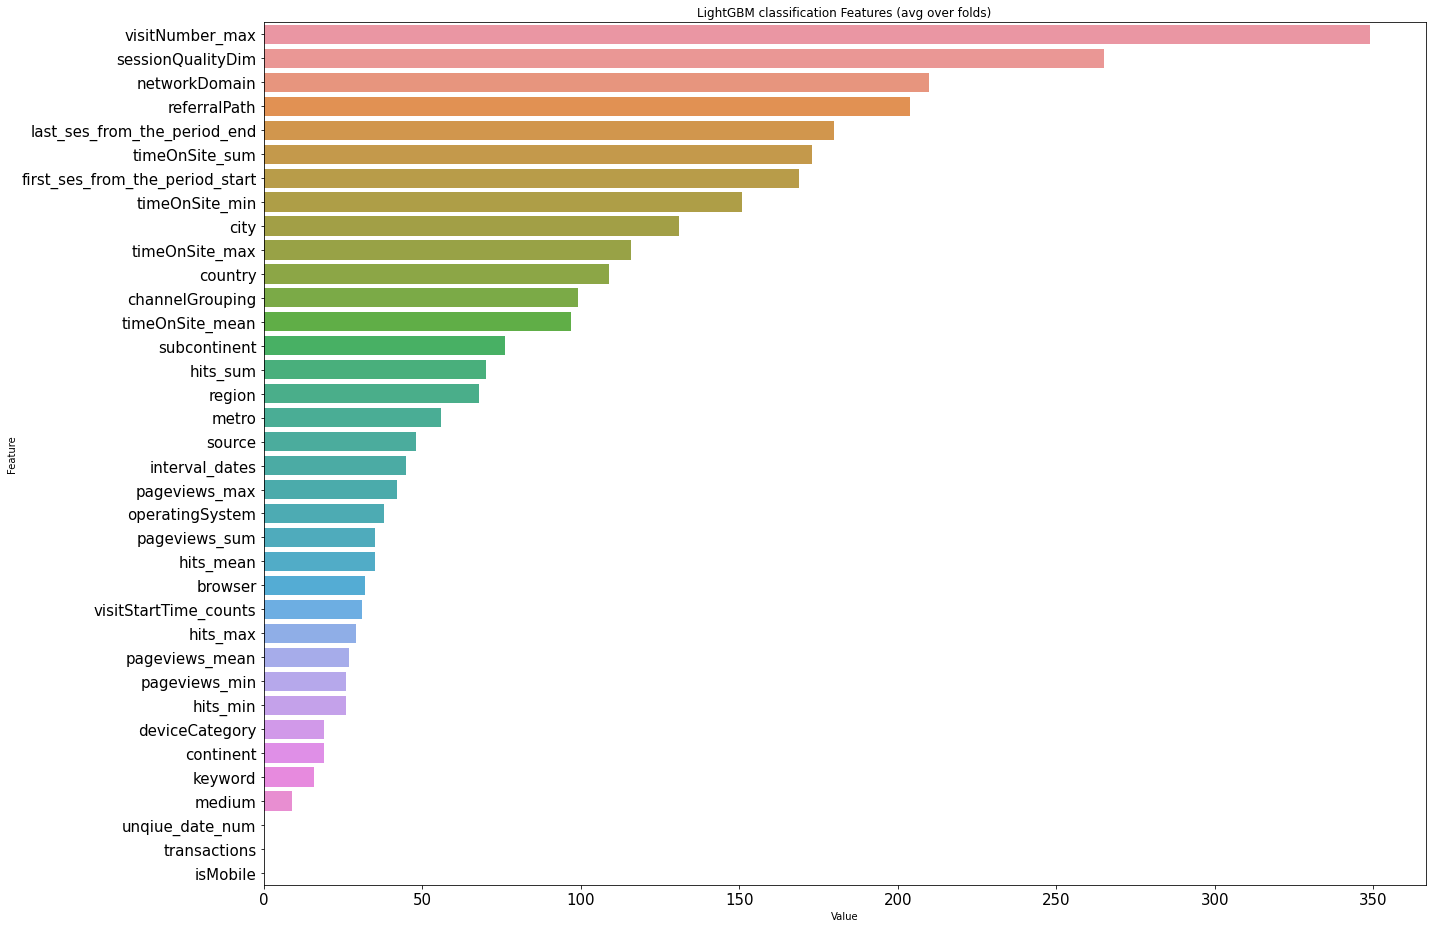

In [151]:
feature_imp = pd.DataFrame(sorted(zip(lgb_model1.feature_importance(), train_df.drop(target_columns, axis=1).columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 13))
plt.rc('ytick', labelsize=15) # y- axis value's font size
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM classification Features (avg over folds)')
plt.tight_layout()
plt.show()

#### Random forest model

In [13]:
#hyper parameter tunining for the model

gridParams = {"n_estimators":[200,400,600,800,1000],
              "max_depth": [2,5,7,9,10],
              "min_samples_split":[2,3,5,7],
              "min_samples_leaf": [1,2,4]
             }

classifier = RandomForestClassifier()

In [14]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']
grid = RandomizedSearchCV(classifier, 
                          gridParams,
                          cv=3,verbose=10)
%time grid.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_depth=7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_depth=7, score=0.998, total= 1.1min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_depth=7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_depth=7, score=0.998, total= 1.0min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_depth=7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_depth=7, score=0.998, total= 1.0min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_depth=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_depth=5, score=0.998, total=  46.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_depth=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.9min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_depth=5, score=0.998, total=  43.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_depth=5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_depth=5, score=0.998, total=  43.7s
[CV] n_estimators=600, min_samples_split=7, min_samples_leaf=4, max_depth=10 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.3min remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=7, min_samples_leaf=4, max_depth=10, score=0.998, total=  43.5s
[CV] n_estimators=600, min_samples_split=7, min_samples_leaf=4, max_depth=10 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.1min remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=7, min_samples_leaf=4, max_depth=10, score=0.998, total=  43.3s
[CV] n_estimators=600, min_samples_split=7, min_samples_leaf=4, max_depth=10 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.8min remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=7, min_samples_leaf=4, max_depth=10, score=0.998, total=  38.8s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=9 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.4min remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=9, score=0.998, total=  27.6s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=9 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=9, score=0.998, total=  27.9s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=9 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=9, score=0.998, total=  27.6s
[CV] n_estimators=800, min_samples_split=7, min_samples_leaf=1, max_depth=9 
[CV]  n_estimators=800, min_samples_split=7, min_samples_leaf=1, max_depth=9, score=0.998, total=  56.7s
[CV] n_estimators=800, min_samples_split=7, min_samples_leaf=1, max_depth=9 
[CV]  n_estimators=800, min_samples_split=7, min_samples_leaf=1, max_depth=9, score=0.998, total=  56.0s
[CV] n_estimators=800, min_samples_split=7, min_samples_leaf=1, max_depth=9 
[CV]  n_estimators=800, min_samples_split=7, min_samples_leaf=1, max_depth=9, score=0.998,

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 21.2min finished


Wall time: 22min 29s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 5, 7, 9, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   verbose=10)

In [15]:
# Print the best parameters found

print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 7}
0.9982532236133362


#### hyper parameter tuning for the "Random forest regressor"

In [16]:
gridParams = {"n_estimators":[200,400,600,800,1000],
              "max_depth": [2,5,7,9,10],
              "min_samples_split":[2,3,5,7],
              "min_samples_leaf": [1,2,4],
              "max_features": ['auto', 'sqrt'],
              'bootstrap': [True, False]
             }

clf = RandomForestRegressor()

In [17]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']
random_search = RandomizedSearchCV(clf, gridParams,cv=3,n_jobs=-1,verbose=10)
%time random_search.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   21.9s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.5s finished


Wall time: 24.8 s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 7, 9, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   verbose=10)

In [18]:
# Print the best parameters found

print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 9, 'bootstrap': False}
1.0


#### Buliding the final model 

In [19]:
classifier = RandomForestClassifier(n_estimators= 800,min_samples_split= 7,min_samples_leaf= 2,max_depth= 7,n_jobs=-1)
regressor  = RandomForestRegressor(n_estimators= 200,min_samples_split=5,min_samples_leaf= 4,max_features= 'sqrt',
                                  max_depth=7,bootstrap= True,n_jobs=-1)

classifier.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])
regressor.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

final_pred = 0             

for i in range(10):
    print("training model : ",i)
     
    classifier_pred = classifier.predict_proba(test_df.drop(target_columns, axis=1))[:,1]
    regressor_pred  = regressor.predict(test_df.drop(target_columns, axis=1))
     
    final_pred      = final_pred + (classifier_pred*regressor_pred)

final_pred /=10 


training model :  0
training model :  1
training model :  2
training model :  3
training model :  4
training model :  5
training model :  6
training model :  7
training model :  8
training model :  9


In [20]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = final_pred

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [21]:
pred_df.to_csv("pred_rf.csv", index=False)

In [22]:
test_data = pd.read_csv('preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},index_col=0) 

test_data = test_data.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [23]:
res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.transactionRevenue'], res['PredictedLogRevenue']))

print(rms)

1.8671201366088064


### Finl model : Logistic regression(for classification)+ Linear regression(for regression):

#### logistic regression:

In [25]:
from sklearn.model_selection import GridSearchCV
target_columns = ['is_returned', 'revenue', 'fullVisitorId']

grid_params={'alpha':[10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}

model      = linear_model.SGDClassifier(loss="log", penalty="l2",class_weight='balanced')

gs         = GridSearchCV(model,grid_params,cv=3,scoring='roc_auc',verbose=2,n_jobs=-1)

gs_results = gs.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])

print(gs_results.best_score_)
print(gs_results.best_params_)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   22.0s finished


0.801351247068054
{'alpha': 1}


#### linear regression 

In [26]:
model=SGDRegressor(loss='squared_loss',penalty='l2')
alpha=[10**-4,10**-3,10**-2,10**-1,1,10,100]

param_grid={"alpha":alpha}

clf = GridSearchCV(model,param_grid, scoring = "neg_root_mean_squared_error", cv=3)
clf.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

print(clf.best_params_)
print(gs_results.best_score_)

{'alpha': 0.0001}
0.801351247068054


In [28]:
classifier      = linear_model.SGDClassifier(loss="log",alpha = 0.01, penalty="l2",class_weight='balanced')
regressor       = SGDRegressor(loss='squared_loss',alpha=0.0001,penalty='l2')


classifier.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])
regressor.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])


classifier_pred = classifier.predict_proba(test_df.drop(target_columns, axis=1))
regressor_pred  = regressor.predict(test_df.drop(target_columns, axis=1))
     
final_pred      = (classifier_pred[:,1]*regressor_pred)

In [30]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df["PredictedLogRevenue"] = final_pred
pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_df.to_csv("pred_linear_models1.csv", index=False)

test_data = pd.read_csv('preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},index_col=0) 
test_data = test_data.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [31]:
res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 
rms = np.sqrt(mean_squared_error(res['totals.transactionRevenue'], res['PredictedLogRevenue']))
print(rms)

1.8671201366088064
